# Auto Regressive (AR) Time-Series Forecasting (sample station: BETN073)

## TODO: Table all mine + previous

- Reading csv all stations + all 51 vars
- Run:
    * AR-1
    * Naive NAR-1
    * DL NAR1


Read all (raw) data CSV:

In [80]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

station = "BETN073"
modelLabel = "rand"

dataManipulation = {
    "detrend": False,
    "scale": None,
#     "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/BETN073_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/BETN073_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/BETN073_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

r = np.delete(r, [0, 1, 3, 55, 56, 58], axis=1)  # Remove all other ts

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:")
print(y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

if not os.path.exists("foundModels/min_mse.pkl"):
    min_mse = sys.float_info.max
    print("Previous min_mse: {}".format(min_mse))
    original_df = pd.DataFrame({"min_mse": [min_mse]})
    original_df.to_pickle("foundModels/min_mse.pkl")
else:
    min_mse = pd.read_pickle("foundModels/min_mse.pkl")['min_mse'][0]
    print("Previous min_mse: {}".format(min_mse))

    if os.path.exists("foundModels/full_{}_parameters.pkl".format(modelLabel)):
        full_model_parameters = pd.read_pickle("foundModels/full_{}_parameters.pkl".format(modelLabel))['full_{}_parameters'.format(modelLabel)][0]
        print("Previous full_{}_parameters: {}".format(modelLabel, full_model_parameters))

Loading data...
Using scale: None
r shape: (8035, 59)

Start Array r:
 12.714
Variables: 52
TimeSteps: 8035
x_data shape: (8035, 52)
y_data shape:
(8035, 1)
Previous min_mse: 175.94445860866549
Previous full_rand_parameters: [1.27000000e+02 2.29000000e+02 1.00000000e+00 4.49000000e+02
 1.97000000e+02 5.70000000e+01 2.32061732e-01 2.42526530e-01
 2.49969796e-01 1.40870453e-01 1.62650739e-01 8.90068722e-02
 1.05907770e-01 1.50517805e-01 5.13129313e-01 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00]


## AR-1

### AR-1 Prediction & metrics

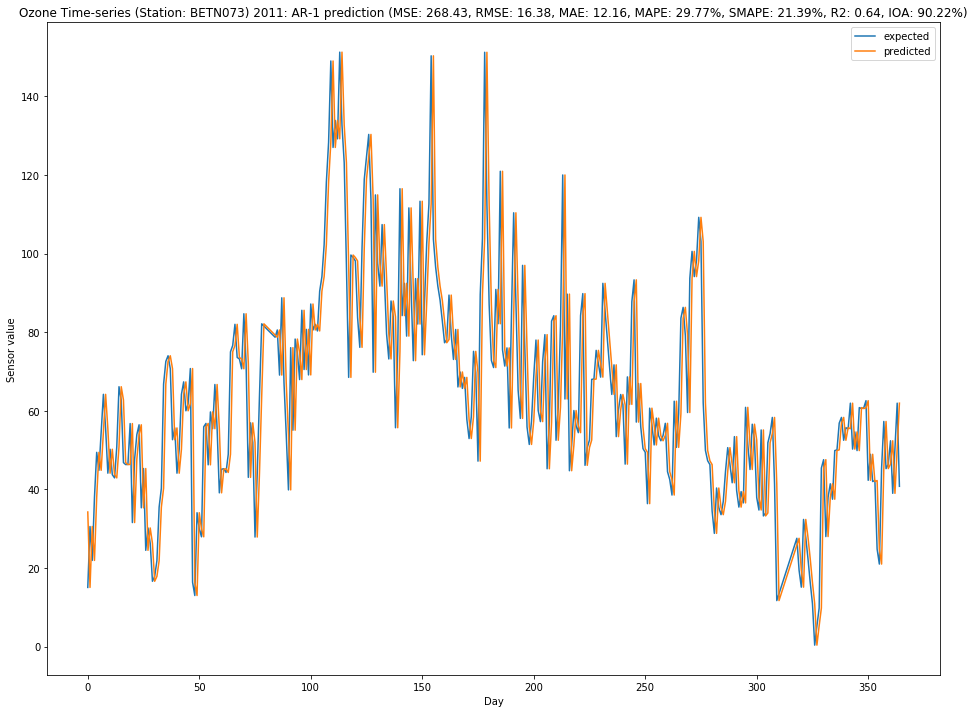

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))) # In %
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 # In %

year = 2011
lag = 1
data = r[-365:,0]
ts_lag1 = r[-365:,52]

MSE = mean_squared_error(data, ts_lag1)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(data, ts_lag1)
MAPE = mean_absolute_percentage_error(data, ts_lag1)
SMAPE = smape(data, ts_lag1)
R2_score = r2_score(data, ts_lag1)
IOA = 1 - (np.sum((data - ts_lag1) ** 2)) / (np.sum(
    (np.abs(ts_lag1 - np.mean(data)) + np.abs(data - np.mean(data))) ** 2))

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Station: {}) {}: AR-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(data)
pyplot.plot(ts_lag1)
ax.legend(['expected', 'predicted'])

# Naive MISO NARX-1

Read standardized data (1 sensor prediction + 51 weather variables):

In [96]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
#     "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/BETN073_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/BETN073_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/BETN073_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

r = np.delete(r, [0, 1, 3, 55, 56, 58], axis=1)  # Remove all other ts

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:")
print(y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

if not os.path.exists("foundModels/min_mse.pkl"):
    min_mse = sys.float_info.max
    print("Previous min_mse: {}".format(min_mse))
    original_df = pd.DataFrame({"min_mse": [min_mse]})
    original_df.to_pickle("foundModels/min_mse.pkl")
else:
    min_mse = pd.read_pickle("foundModels/min_mse.pkl")['min_mse'][0]
    print("Previous min_mse: {}".format(min_mse))

    if os.path.exists("foundModels/full_{}_parameters.pkl".format(modelLabel)):
        full_model_parameters = pd.read_pickle("foundModels/full_{}_parameters.pkl".format(modelLabel))['full_{}_parameters'.format(modelLabel)][0]
        print("Previous full_{}_parameters: {}".format(modelLabel, full_model_parameters))

Loading data...
Using scale: standardize
r shape: (8035, 59)

Start Array r:
 -1.629934901667087
Variables: 52
TimeSteps: 8035
x_data shape: (8035, 52)
y_data shape:
(8035, 1)
Previous min_mse: 175.94445860866549
Previous full_rand_parameters: [1.27000000e+02 2.29000000e+02 1.00000000e+00 4.49000000e+02
 1.97000000e+02 5.70000000e+01 2.32061732e-01 2.42526530e-01
 2.49969796e-01 1.40870453e-01 1.62650739e-01 8.90068722e-02
 1.05907770e-01 1.50517805e-01 5.13129313e-01 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00]


## LSTM Multiple-Input Single-Output (MISO) Nonlinear AutoRegressive eXogenous model with lag of 1 day (NARX-1)

Load the a model (best after 10 random hyper-parameter search iterations) & its weights:

In [97]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

from __future__ import print_function
import numpy as np
from keras.models import model_from_json
import pandas as pd

json_file = open('runs/2gpuRand1stationNarx1/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpuRand1stationNarx1/foundModels/bestModelWeights.h5")

Model shape:
- 3 stacked Bi-directional Long-Short Term Memory (LSTM) cells with 1 gaussian noise cell:
![title](runs/2gpuRand1stationNarx1/foundModels/randModelIter4.png)

In [98]:
sensor_mean = pd.read_pickle("data/BETN073_ts_mean.pkl")
sensor_std = pd.read_pickle("data/BETN073_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

In [99]:
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

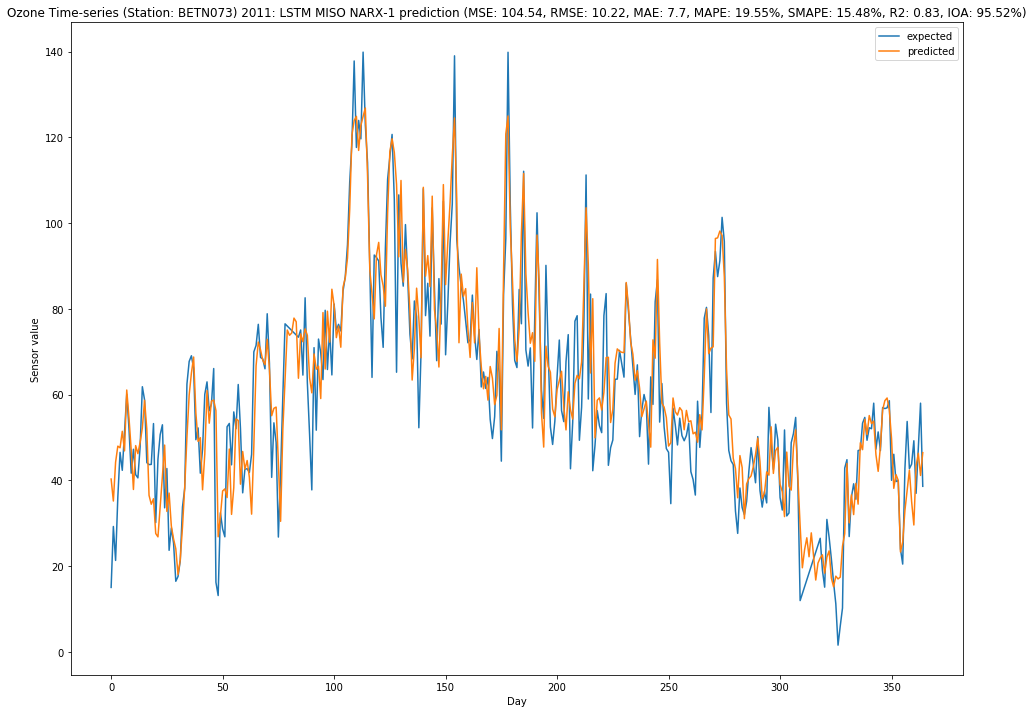

In [101]:
holdout_prediction = loaded_model.predict(x_data_holdout)

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = 1 - (np.sum((y_validation - prediction) ** 2)) / (np.sum(
    (np.abs(prediction - np.mean(y_validation)) + np.abs(y_validation - np.mean(data))) ** 2))

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Station: {}) {}: LSTM MISO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])

# LSTM Multiple-Input Multiple-Output (MIMO) NARX-1 for 4 stations (BETN022, BETN066, BETN073, BETN121)

Read standardized data (4 sensors prediction):

In [91]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
#     "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/BETN073_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/BETN073_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/BETN073_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 4
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:")
print(y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

if not os.path.exists("foundModels/min_mse.pkl"):
    min_mse = sys.float_info.max
    print("Previous min_mse: {}".format(min_mse))
    original_df = pd.DataFrame({"min_mse": [min_mse]})
    original_df.to_pickle("foundModels/min_mse.pkl")
else:
    min_mse = pd.read_pickle("foundModels/min_mse.pkl")['min_mse'][0]
    print("Previous min_mse: {}".format(min_mse))

    if os.path.exists("foundModels/full_{}_parameters.pkl".format(modelLabel)):
        full_model_parameters = pd.read_pickle("foundModels/full_{}_parameters.pkl".format(modelLabel))['full_{}_parameters'.format(modelLabel)][0]
        print("Previous full_{}_parameters: {}".format(modelLabel, full_model_parameters))

Loading data...
Using scale: standardize
r shape: (8035, 59)

Start Array r:
 -1.7234439343050418
Variables: 58
TimeSteps: 8035
x_data shape: (8035, 55)
y_data shape:
(8035, 4)
Previous min_mse: 175.94445860866549
Previous full_rand_parameters: [1.27000000e+02 2.29000000e+02 1.00000000e+00 4.49000000e+02
 1.97000000e+02 5.70000000e+01 2.32061732e-01 2.42526530e-01
 2.49969796e-01 1.40870453e-01 1.62650739e-01 8.90068722e-02
 1.05907770e-01 1.50517805e-01 5.13129313e-01 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00]


Load the model:

In [90]:
json_file = open('runs/2gpuRandNarx1/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpuRandNarx1/foundModels/bestModelWeights.h5")

Model shape:
- 3 stacked Bi-directional Long-Short Term Memory (LSTM) cells with 1 gaussian noise cell:
![title](runs/2gpuRand1stationNarx1/foundModels/randModelIter4.png)

In [92]:
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = 1 - (np.sum((y_validation - prediction) ** 2)) / (np.sum(
    (np.abs(prediction - np.mean(y_validation)) + np.abs(y_validation - np.mean(data))) ** 2))

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Stations: {}) {}: LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(4, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])